# TPS 02-2022: Linear Classifiers

We test out several linear classifiers (mostly from `sklearn.linear_model`) with various preprocessing steps to see which give the best results on a small subset of the training data.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 4

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import re
import math
import os
import pyarrow
import gc

# scikit-learn optimization
from sklearnex import patch_sklearn
patch_sklearn()

# Model evaluation
import optuna
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image


# Hide warnings
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Helper Functions

In [3]:
# Helper functions from https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense/
from math import factorial
from random import choices, setstate
from collections import Counter
from itertools import product

def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return bias(w, x, y, z)

def get_histograms(input_df):
    return pd.DataFrame({
        col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
    })

def gcd_of_all(df_i):
    gcd = df_i[features[0]]
    for col in features[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

def get_target_bins():
    temp = train[['target','target']].copy()
    temp.columns = ['row_id','target']
    temp['row_id'] = gcd_of_all(get_histograms(train[features]))
    return temp['row_id'].astype(str) + temp['target'].astype(str)


def remove_duplicates(input_df):
    # Create a new dataframe without duplicates, but with an additional sample_weight column
    vc = input_df[features + ['target']].value_counts()
    dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns = input_df[features + ['target']].columns)
    dedup_train['sample_weight'] = vc.values
    return dedup_train

# Scoring Function

In [4]:
# Scoring/Training Baseline Function
def score_model(sklearn_model, preprocessing = None):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, get_target_bins())):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx].to_numpy(), train['target'].iloc[train_idx].to_numpy()
        X_valid, y_valid = train[features].iloc[valid_idx].to_numpy(), train['target'].iloc[valid_idx].to_numpy()
        
        # Preprocessing
        start = time.time()
        if preprocessing:
            X_train = preprocessing.fit_transform(X_train)
            X_valid = preprocessing.transform(X_valid)
        
        # Create model
        model = clone(sklearn_model)
        model.fit(
            X_train, y_train, 
            sample_weight = train['sample_weight'].iloc[train_idx]
        )

        
        # validation
        valid_preds = model.predict(X_valid)
        scores[fold] = accuracy_score(y_valid, valid_preds)
        oof_preds[valid_idx] = valid_preds
        end = time.time()
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(end-start,2)}s.')
        times[fold] = end-start
        
        
    print("\nAccuracy (1M Reads):", round(accuracy_score(oof_preds[train_gcds == 1], train['target'].loc[train_gcds == 1]), 5))
    print("Accuracy (100k Reads):", round(accuracy_score(oof_preds[train_gcds == 10], train['target'].loc[train_gcds == 10]), 5))
    print("Accuracy (1k Reads):", round(accuracy_score(oof_preds[train_gcds == 1000], train['target'].loc[train_gcds == 1000]), 5))
    print("Accuracy (100 Reads):", round(accuracy_score(oof_preds[train_gcds == 10000], train['target'].loc[train_gcds == 10000]), 5))
    print("Average Accuracy:", round(scores.mean(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return oof_preds
    

# Confusion Matrix Plotting

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_values, pred_values, gcds, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Confusion matrix
    fig, ax = plt.subplots(2, 2, figsize = (12,9))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
    plt.show()

# Load Data

In [6]:
%%time
from sklearn.preprocessing import LabelEncoder

train = pd.read_feather('../data/train.feather')
features = [x for x in train.columns if x not in ['row_id', 'target']]

# Label encoding
encoder = LabelEncoder()
train['target'] = encoder.fit_transform(train['target'])
train = remove_duplicates(train)
train_gcds = gcd_of_all(get_histograms(train[features]))

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: total: 16.7 s
Wall time: 15.1 s


# 1. Logistic Regression

We test out several logistic regression pipelines involving different preprocessing steps such as feature scaling and PCA-based dimension reduction as well as regularization. 

From a grid search, we find that the ideal combination is are the parameters: `solver = 'sag'` with the `MinMaxScaler`. So, we will prefer the SAG solver but use SAGA solver if necessary (e.g. for testing L1 regularization).

In [7]:
# Model
from sklearn.linear_model import LogisticRegression

# Preprocessing 
from sklearn.preprocessing import MinMaxScaler

## 1.1 Baseline


Fold 0: 0.86238 accuracy in 101.25s.
Fold 1: 0.89912 accuracy in 97.93s.
Fold 2: 0.89964 accuracy in 97.22s.
Fold 3: 0.87912 accuracy in 97.12s.

Accuracy (1M Reads): 0.93239
Accuracy (100k Reads): 0.95847
Accuracy (1k Reads): 0.79526
Accuracy (100 Reads): 0.60063
Average Accuracy: 0.88507
Training Time: 393.51s


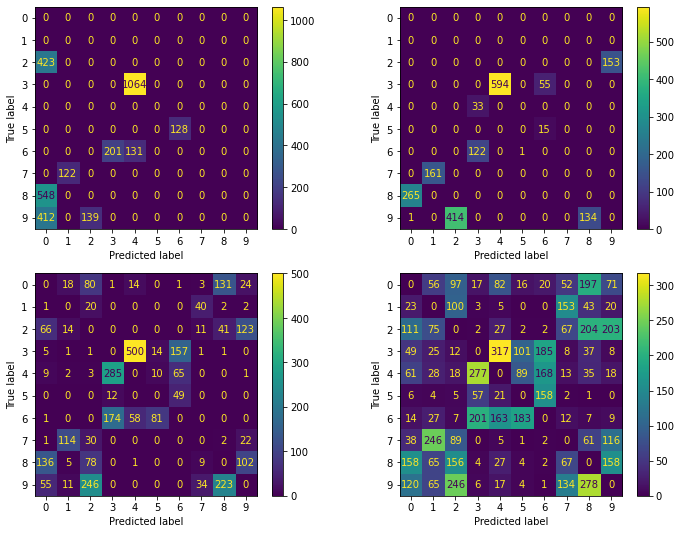

In [8]:
# Logistic Regression
oof_preds = score_model(
    LogisticRegression(
        penalty = 'none', 
        solver = 'saga', 
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
    MinMaxScaler()
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

## 1.2 Lasso


Fold 0: 0.85116 accuracy in 242.95s.
Fold 1: 0.88428 accuracy in 243.15s.
Fold 2: 0.77124 accuracy in 243.03s.
Fold 3: 0.88332 accuracy in 244.66s.

Accuracy (1M Reads): 0.89393
Accuracy (100k Reads): 0.90179
Accuracy (1k Reads): 0.79049
Accuracy (100 Reads): 0.59237
Average Accuracy: 0.8475
Training Time: 973.8s


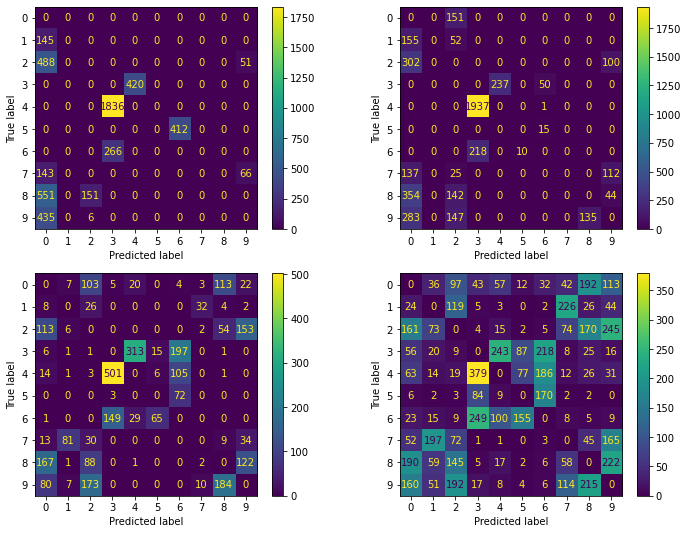

In [9]:
# L1 Regularization
oof_preds = score_model(
    LogisticRegression(
        penalty = 'l1', 
        solver = 'saga', 
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
    MinMaxScaler()
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

## 1.3 Ridge


Fold 0: 0.75351 accuracy in 71.13s.
Fold 1: 0.82118 accuracy in 71.02s.
Fold 2: 0.74011 accuracy in 71.43s.
Fold 3: 0.80454 accuracy in 70.85s.

Accuracy (1M Reads): 0.82422
Accuracy (100k Reads): 0.82658
Accuracy (1k Reads): 0.72418
Accuracy (100 Reads): 0.55306
Average Accuracy: 0.77983
Training Time: 284.43s


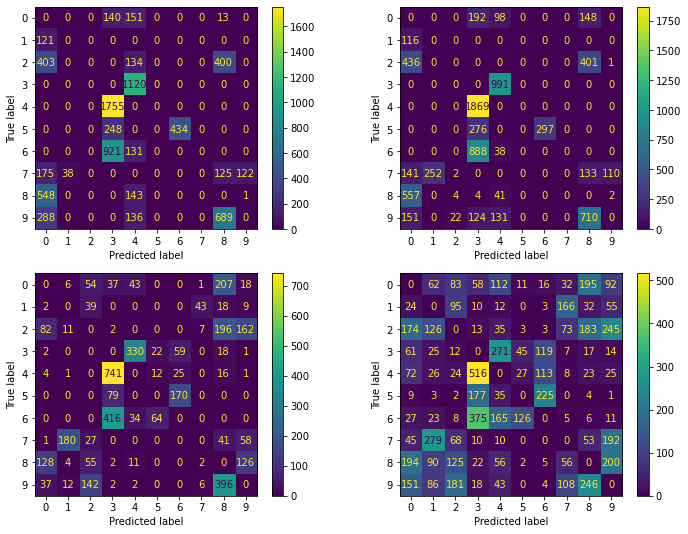

In [10]:
# L2 Regularization
oof_preds = score_model(
    LogisticRegression(
        penalty = 'l2', 
        solver = 'sag', 
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
    MinMaxScaler()
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

## 1.4 Elasticnet


Fold 0: 0.87725 accuracy in 250.81s.
Fold 1: 0.88922 accuracy in 250.36s.
Fold 2: 0.85944 accuracy in 252.69s.
Fold 3: 0.81615 accuracy in 252.0s.

Accuracy (1M Reads): 0.91345
Accuracy (100k Reads): 0.91351
Accuracy (1k Reads): 0.80645
Accuracy (100 Reads): 0.5863
Average Accuracy: 0.86052
Training Time: 1005.85s


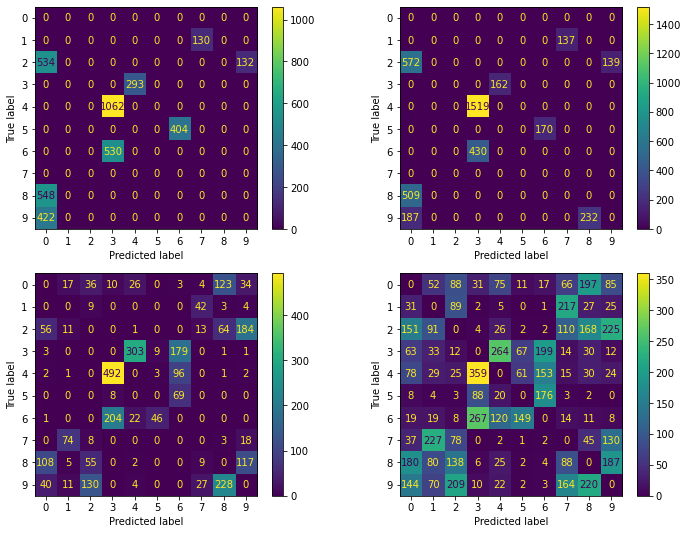

In [11]:
# Elasticnet Regularization
oof_preds = score_model(
    LogisticRegression(
        penalty = 'elasticnet', 
        solver = 'saga', 
        l1_ratio = 0.15,
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
    MinMaxScaler()
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

# 2. SGDClassifier

In [12]:
# Model
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler


Fold 0: 0.85364 accuracy in 130.19s.
Fold 1: 0.81299 accuracy in 126.35s.
Fold 2: 0.80625 accuracy in 126.27s.
Fold 3: 0.83851 accuracy in 126.31s.

Accuracy (1M Reads): 0.9062
Accuracy (100k Reads): 0.87972
Accuracy (1k Reads): 0.72716
Accuracy (100 Reads): 0.52491
Average Accuracy: 0.82784
Training Time: 509.12s


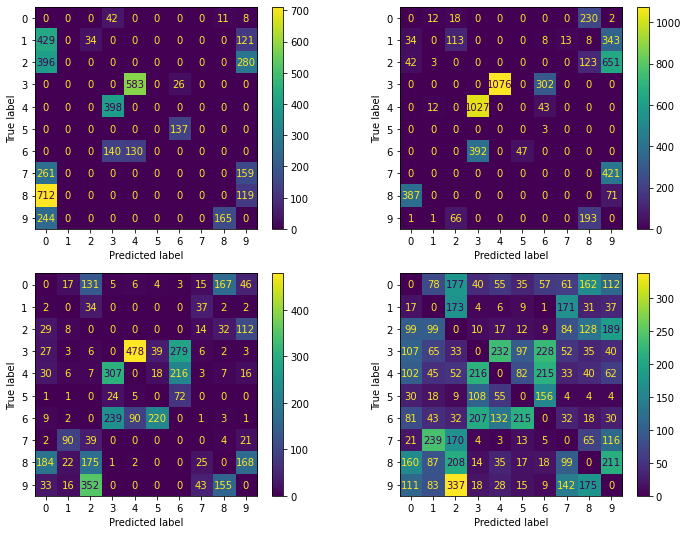

In [13]:
# None
oof_preds = score_model(
    SGDClassifier(
            penalty = None,
            n_jobs = -1,
            random_state = RANDOM_SEED,
    ),
    StandardScaler()
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

# 3. Linear SVC

The default `SGDClassifier` is very similar to `LinearSVC`, but we check it separately since it's likely to outperform it.

In [14]:
from sklearn.svm import SVC


Fold 0: 0.92258 accuracy in 114.83s.
Fold 1: 0.92177 accuracy in 134.56s.
Fold 2: 0.91593 accuracy in 170.01s.
Fold 3: 0.91896 accuracy in 125.52s.

Accuracy (1M Reads): 0.98455
Accuracy (100k Reads): 0.96617
Accuracy (1k Reads): 0.83281
Accuracy (100 Reads): 0.66248
Average Accuracy: 0.91981
Training Time: 544.92s


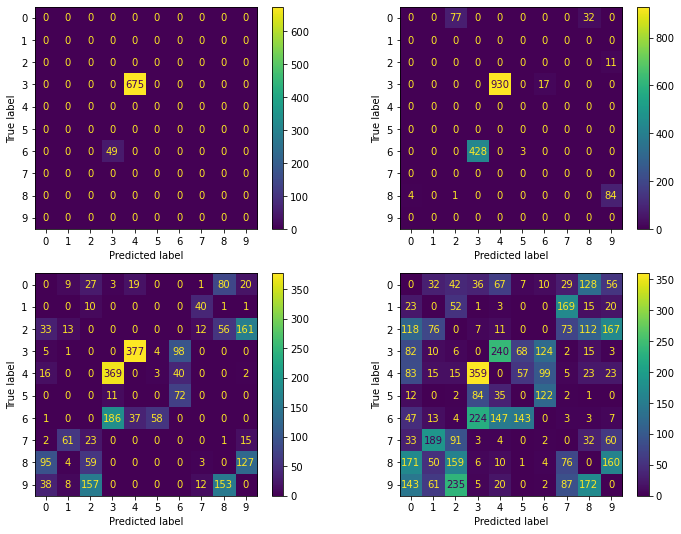

In [15]:
# Standard
oof_preds = score_model(
    SVC(
        kernel = 'linear',
        random_state = RANDOM_SEED,
    ),
    StandardScaler()
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)